<a href="https://colab.research.google.com/github/20KMJ/ESAA7/blob/main/1007.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. 사이킷런으로 수행하는 타이타닉 생존자 예측

> **타이타닉 탑승자 데이터**
> * Passengerid: 탑승자 데이터 일련번호
> * survived: 생존 여부, 0 = 사망, 1 = 생존
> * pclass: 티켓의 선실 등급, 1 = 일등석, 2 = 이등석, 3 = 삼등석
> * sex: 탑승자 성별
> * rename: 탑승자 이름
> * Age: 탑승자 나이
> * sibsp: 같이 탑승한 형제자매 또는 배우자 인원수
> * parch: 같이 탑승한 부모님 또는 어린이 인원수
> * ticket: 티켓 번호
> * fare: 요금
> * cabin: 선실 번호
> * embarked: 중간 정착 항구 C = Cherbourg, Q = Queenstown, S = Southampton

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

titanic_df = pd.read_csv('./titanic_train.csv')
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [ ]:
print('\n ### 학습 데이터 정보 ### \n')
print(titanic_df.info())


 ### 학습 데이터 정보 ### 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [ ]:
# NULL 값 처리
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)
titanic_df['Cabin'].fillna('N', inplace=True)
titanic_df['Embarked'].fillna('N', inplace=True)
print('데이터 세트 Null 값 개수 ', titanic_df.isnull().sum().sum())

데이터 세트 Null 값 개수  0


In [ ]:
# 문자열 피처 Sex, Cabin, Emabarked 들의 값 분류 살펴보기
print(' Sex 값 분포 :\n', titanic_df['Sex'].value_counts())
print('\n Cabin 값 분포 :\n', titanic_df['Cabin'].value_counts())
print('\n Embarked 값 분포 :\n', titanic_df['Embarked'].value_counts())

 Sex 값 분포 :
 male      577
female    314
Name: Sex, dtype: int64

 Cabin 값 분포 :
 G6             4
B96 B98        4
C23 C25 C27    4
F33            3
E101           3
              ..
D46            1
D11            1
D45            1
A24            1
C148           1
Name: Cabin, Length: 147, dtype: int64

 Embarked 값 분포 :
 S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [ ]:
# Cabin 속성의 경우 앞 문자(선실 등급)만 추출하기
titanic_df['Cabin'] = titanic_df['Cabin'].str[:1]
print(titanic_df['Cabin'].head(3))

0    N
1    C
2    N
Name: Cabin, dtype: object


In [ ]:
# 성별이 생존 확률에 미친 영향
# 0: 사망; 1: 생존
titanic_df.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

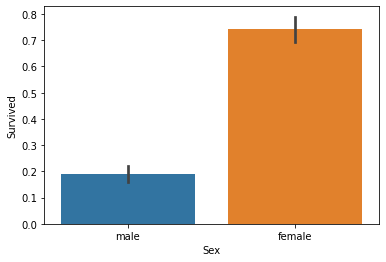

In [ ]:
# 그래프 확인
# 막대의 높이: Sex별 Survived의 평균
sns.barplot(x='Sex', y='Survived', data=titanic_df)

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

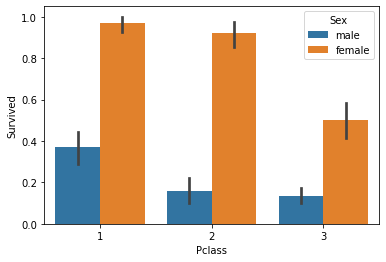

In [ ]:
# 부자와 가난한 사람 간의 생존 확률 (+ 성별)
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=titanic_df)

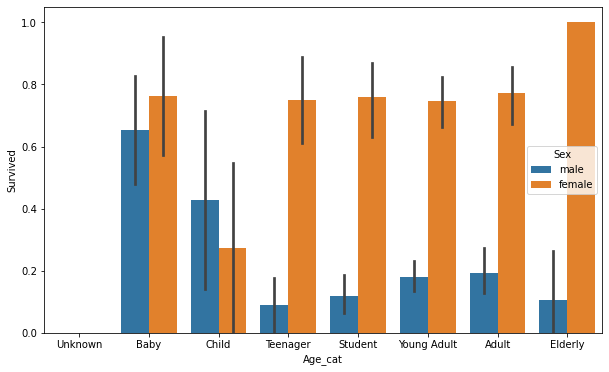

In [ ]:
# Age에 따른 생존 확률
# 0~5세: Baby, 6~12세: Child, 13~18세: Teenager, 19~25세: Student
# 26~35세: Young Adult, 36~60세: Adult, 61세 이상: Elderly, 오류값: Unknown

# 입력 age에 따라 구분 값을 반환하는 함수 설정. DataFrame의 apply lambda 식에 사용.
def get_category(age):
    cat = ''
    if age <= -1: cat = 'Unknown'
    elif age <= 5: cat = 'Baby'
    elif age <= 12: cat = 'Child'
    elif age <= 18: cat = 'Teenager'
    elif age <= 25: cat = 'Student'
    elif age <= 35: cat = 'Young Adult'
    elif age <= 60: cat = 'Adult'
    else : cat = 'Elderly'
        
    return cat

# 막대그래프의 크기 figure를 더 크게 설정
plt.figure(figsize=(10,6))

# X축의 값을 순차적으로 표시하기 위한 설정
group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']

# lambda 식에 위에서 생성한 get_category() 함수를 반환값으로 지정.
# get_category(X)는 입력값으로 'Age' 칼럼 값을 받아서 해당하는 cat 반환
titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x : get_category(x))
sns.barplot(x='Age_cat', y='Survived',hue='Sex', data=titanic_df, order=group_names)
titanic_df.drop('Age_cat', axis=1, inplace=True)

> **LabelEncoder**  
> 카테고리 값의 유형 수에 따라 0 ~ (카테고리 유형 수-1)까지의 숫자값으로 변환해주는 사이킷런의 클래스

In [ ]:
# encode_features() 함수 만들기 (문자열 카테고리 피처 -> 숫자형 카테고리 피처)
from sklearn import preprocessing

def encode_features(dataDF):
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(dataDF[feature])
        dataDF[feature] = le.transform(dataDF[feature])
        
    return dataDF

titanic_df = encode_features(titanic_df)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,3


In [ ]:
# 데이터 전처리 함수 종합

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace = True)
    df['Embarked'].fillna('N', inplace = True)
    df['Fare'].fillna(0, inplace = True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출 (최종 함수)
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [ ]:
# 원본 데이터를 재로딩하고, 피처 데이터 세트와 레이블 데이터 세트 추출.
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)

X_titanic_df = transform_features(X_titanic_df)

In [ ]:
# 별도의 테스트 데이터 세트 추출
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,
                                                   test_size=0.2, random_state=11)

In [ ]:
# 결정 트리, 랜덤 포레스트, 로지스틱 회귀 이용하여 타이타닉 생존자 예측하기
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 결정트리, Random Forest, 로지스틱 회귀를 위한 사이킷런 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier()
rf_clf = RandomForestClassifier()
lr_clf = LogisticRegression()

# DecisionTreeCLassifier 학습/예측/평가
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))

# RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))

# LogisticRegression 학습/예측/평가
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
print('LogisticRegression 정확도: {0:.4f}'.format(accuracy_score(y_test, lr_pred)))

DecisionTreeClassifier 정확도: 0.7989
RandomForestClassifier 정확도: 0.8547
LogisticRegression 정확도: 0.8492


In [ ]:
# 교차 검증으로 결정 트리 모델 평가
# KFold 교차 검증

from sklearn.model_selection import KFold

def exec_kfold(clf, folds=5):
    # 폴드 세트를 5개인 KFold객체를 생성, 폴드 수만큼 예측결과 저장을 위한 리스트 객체 생성.
    kfold = KFold(n_splits=folds)
    scores=[]
    
    # KFold 교차 검증 수행.
    for iter_count, (train_index, test_index) in enumerate(kfold.split(X_titanic_df)):
        # X_titanic_df 데이터에서 교차 검증별로 학습과 검증 데이터를 가리키는 index 생성
        X_train, X_test = X_titanic_df.values[train_index], X_titanic_df.values[test_index]
        y_train, y_test = y_titanic_df.values[train_index], y_titanic_df.values[test_index]
        # Classifier 학습, 예측, 정확도 계산
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        scores.append(accuracy)
        print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))
    
    # 5개의 fold에서의 평균 정확도 계산.
    mean_score = np.mean(scores)
    print("평균 정확도: {0:.4f}".format(mean_score))
    
# exec_kfold 호출
exec_kfold(dt_clf, folds=5)

교차 검증 0 정확도: 0.7430
교차 검증 1 정확도: 0.7584
교차 검증 2 정확도: 0.8090
교차 검증 3 정확도: 0.7697
교차 검증 4 정확도: 0.8258
평균 정확도: 0.7812


In [ ]:
# cross_val_score() API를 이용한 교차 검증
# StratifiedKFold
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf, X_titanic_df, y_titanic_df, cv=5)
for iter_count, accuracy in enumerate(scores):
    print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))
    
print("평균 정확도: {0:.4f}".format(np.mean(scores)))

교차 검증 0 정확도: 0.7486
교차 검증 1 정확도: 0.7809
교차 검증 2 정확도: 0.7921
교차 검증 3 정확도: 0.7809
교차 검증 4 정확도: 0.8146
평균 정확도: 0.7834


In [ ]:
# GridSearchCV를 이용해 DecisionTreeClassifier의 최적 하이퍼 파라미터를 찾고 예측 성능 측정하기
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[2, 3, 5, 10],
              'min_samples_leaf':[1, 5, 8], 'min_samples_split':[2, 3, 5]}

grid_dclf = GridSearchCV(dt_clf, param_grid=parameters, scoring='accuracy', cv=5)
grid_dclf.fit(X_train, y_train)

print('GridSearchCV 최적 하이퍼 파라미터 :', grid_dclf.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

# GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행.
dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test, dpredictions)
print('테스트 세트에서의 DecisionTreeClassifier 정확도 : {0:.4f}'.format(accuracy))

GridSearchCV 최적 하이퍼 파라미터 : {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.7992
테스트 세트에서의 DecisionTreeClassifier 정확도 : 0.8715


# 07. 정리

* 지금까지 사이킷런을 기반으로 머신러닝 애플리케이션을 구현해 보았음.
* **사이킷런**은 매우 많은 머신러닝 알고리즘을 제공할 뿐만 아니라, 쉽고 직관적인 API 프레임워크, 편리하고 다양한 모듈 지원 등으로 파이썬 계열의 대표적인 머신러닝 패키지로 자리 잡았음.

* **머신러닝 애플리케이션**은
1. 데이터의 가공 및 변환 과정의 전처리 작업
2. 데이터를 학습 데이터와 테스트 데이터로 분리하는 데이터 세트 분리 작업을 거친 후에
3. 학습 데이터를 기반으로 머신러닝 알고리즘을 적용해 모델을 학습시킴
4. 그리고 학습된 모델을 기반으로 테스트 데이터에 대한 예측을 수행하고
5. 이렇게 예측된 결괏값을 실제 결괏값과 비교해 머신러닝 모델에 대한 평가를 수행하는 방식으로 구성됨.

* **데이터 전처리 작업**은 오류 데이터의 보정이나 결손값(Null) 처리 등의 다양한 *데이터 클렌징 작업*, 레이블 인코딩이나 원-핫 인코딩과 같은 *인코딩 작업*, 그리고 데이터의 *스케일링/정규화 작업* 등으로 머신러닝 알고리즘이 최적으로 수행될 수 있게 데이터를 사전 처리하는 것.

* 머신러닝 모델은 학습 데이터 세트로 학습한 뒤 반드시 별도의 테스트 데이터 세트로 평가되어야 함.
* 또한 테스트 데이터의 건수 부족이나 고정된 테스트 데이터 세트를 이용한 반복적인 모델의 학습과 평가는 해당 테스트 데이터 세트에만 치우친 빈약한 머신러닝 모델을 만들 가능성이 높음.
* 이를 해결하기 위해 학습 데이터 세트를 학습 데이터와 검증 데이터로 구성된 여러 개의 폴드 세트로 분리해 **교차 검증**을 수행할 수 있음.
* 사이킷런은 이러한 교차 검증을 지원하기 위해 **KFold, StratifiedKFold, cross_val_score()** 등의 다양한 클래스와 함수를 제공함. 또한 머신러닝 모델의 **최적의 하이퍼 파라미터**를 교차 검증을 통해 추출하기 위해 **GridSearchCV**를 제공함.